In [1]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
def plot_1D(X):
    K, _, T = X.shape
    cmap = plt.cm.viridis  
    for k in range(K):
        for t in range(T - 1):
            plt.plot([t, t + 1], [X[k, 0, t], X[k, 0, t + 1]], color=cmap(t / (T - 1)))

0.00048685074
0.0004518589


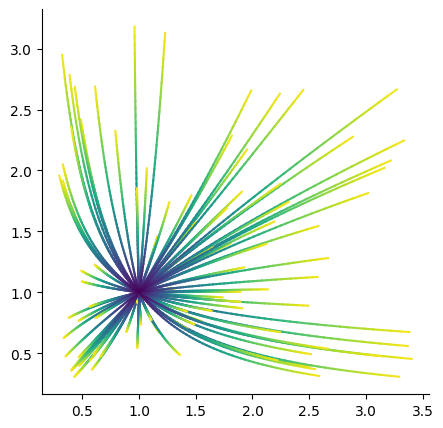

In [2]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)


K = 100
T = 50

# time = jnp.linspace(0, 2 *jnp.pi, T)[:, jnp.newaxis] #4
# radii = jnp.linspace(0.1, 2, K)
# radii = random.permutation(key, radii)
# phases = jnp.linspace(0, 2*jnp.pi, K)

# sine_waves = jnp.sin(time + phases) * radii
# cosine_waves = jnp.cos(time + phases) * radii
# X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200

# r = radii * jnp.cos(time + phases)
# theta = radii * jnp.sin(time + phases)
# x = r * np.cos(theta)
# y = r * np.sin(theta)
# X = jnp.stack([x.T, y.T], axis=1)

# mean = 0
# std_dev = 1
# trajectories_1 = np.random.normal(loc=mean, scale=std_dev, size=(num_trajectories, time_steps))
# trajectories_2 = np.random.normal(loc=mean, scale=std_dev, size=(num_trajectories, time_steps))
# combined_trajectories = np.stack((trajectories_1, trajectories_2), axis=1)
# X = jnp.concatenate((X, jnp.array(combined_trajectories)), axis=1)

# proj_dims = 10
# proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
# proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
# X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)

# noise = random.normal(key, (X.shape)) 
# X += 0.01 * (noise)  

initial_rates = 0.05 * (random.uniform(key, shape=(K, 2, 1)) - 0.5)
#initial_rates = 0.1 * (random.uniform(key, shape=(K, 1, 1)) - 0.5)
time_steps = jnp.arange(T)
X = jnp.exp(initial_rates * time_steps)
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)



plot_2D(X)

print(np.mean(compute_S(X)))
print(compute_S_all_pairs(X))

In [4]:
d = 2

In [ ]:
kernel_function=K_X_Y_rational_quadratic
c = 30

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=500, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )




In [ ]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H  = get_alpha(params, A, X, kernel_function, d)


X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_1D(Y[:,:,:])
plt.title(f's = {compute_S_all_pairs(Y)}')


Iteration 0, S: 35.484798431396484, S_ratio: 0.0004282772133592516
Iteration 10, S: 139.0303955078125, S_ratio: 0.001842982484959066
Iteration 20, S: 50.873600006103516, S_ratio: 0.0007205238798633218
Iteration 30, S: 53.87199783325195, S_ratio: 0.0007198972743935883
Iteration 40, S: 77.27679443359375, S_ratio: 0.0010122652165591717
Iteration 50, S: 39.8656005859375, S_ratio: 0.000520533649250865
Iteration 60, S: 75.12639617919922, S_ratio: 0.0009198035695590079
Iteration 70, S: 70.99839782714844, S_ratio: 0.0007629247847944498
Iteration 80, S: 1.0591999292373657, S_ratio: 1.4426607776840683e-05
Iteration 90, S: 67.85919952392578, S_ratio: 0.0008321335772052407
Iteration 100, S: 37.295997619628906, S_ratio: 0.0005256824661046267
Iteration 110, S: 15.631999969482422, S_ratio: 0.00018796983931679279
Iteration 120, S: 69.62559509277344, S_ratio: 0.0008201692253351212
Iteration 130, S: 74.93439483642578, S_ratio: 0.0008275306900031865
Iteration 140, S: 51.97439956665039, S_ratio: 0.0007162

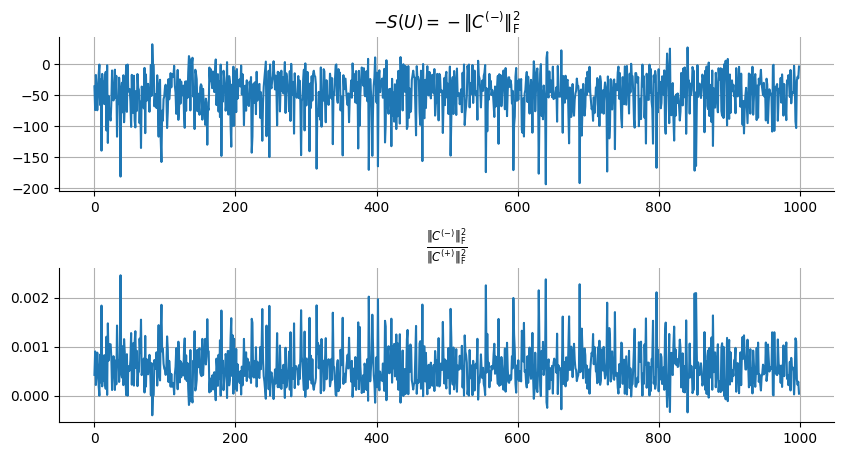

In [5]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X, d=d, learning_rate=0.01, iterations=1000) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


Text(0.5, 1.0, 's = 0.00045185760245658457')

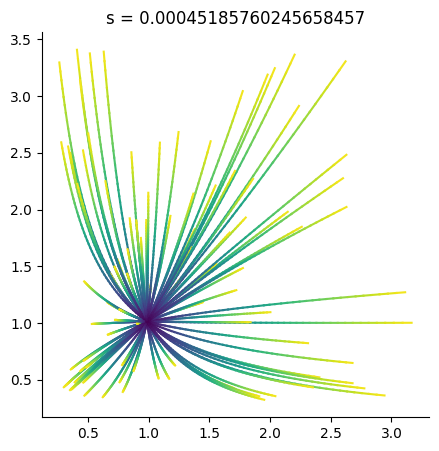

In [7]:

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
plot_2D(Y)
plt.title(f's = {compute_S_all_pairs(Y)}')